# Setup

In [47]:
import os
from collections import Counter
from datetime import timedelta
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/P5_Segmentez les comportements de clients')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes

In [49]:
SEGMENTS = ['Platinum', 'Gold', 'Silver', 'Bronze']

# Fonctions

In [50]:
def flatten_cols(df):
    """
    Enable to aplanish column names of multi-index dataframe
    """
    temp = df.copy()
    cols = []
    for i, j in temp.columns:
        if j == "":
            j = i
        cols.append(j)
    temp.columns = cols
    return temp

def preprocess_df(df):
    """
    To agregate data from Online Retails data set
    """

    temp = df.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate'])\
             .agg({'StockCode': [('lines', 'count'), \
                                 ('n_pdt', lambda x: len(x.unique()))], \
                   'TotalPrice': [('basket_price', 'sum'), \
                                  ('mean_price', 'mean')], \
                   }).round(2).reset_index()
    temp = flatten_cols(temp)

    temp = temp.groupby('CustomerID')\
               .agg({'InvoiceDate': [\
                                     # récence
                                     ('recency', \
                                      lambda x: (d_study - x.max()).days), \
                                     # durée entre le 1° et le dernier achat
                                     ('duration', \
                                      lambda x: (x.max() - x.min()).days + 1)], \
                     # nb commandes distinctes
                     'InvoiceNo': [('orders', lambda x: len(x.unique()))], \
                     # nombre de produits total achetés par un utilisateur
                     'lines': [('frequency', 'sum'), \
                               # quantité moyenne par transaction
                               ('line_mean', 'mean')], \
                     # nb moyen d'articles différents par achat
                     'n_pdt': [('pdt_mean', 'mean')], \
                     # montant total des commandes
                     'basket_price': [('monetary_value', 'sum')], \
                     # prix moyen des produits achetés par transaction
                     'mean_price': [('price_mean', 'mean')]\
                     }).round(2).reset_index()
    temp = flatten_cols(temp)

    # nb de produits différents achetés par un utilisateur
    pdt = df.groupby('CustomerID')\
            .agg({'StockCode': [('nb_pdt', lambda x: len(x.unique()))]})\
            .reset_index()
    pdt = flatten_cols(pdt)

    return temp.merge(pdt)

def add_rfm(x):
    """
    Return R/F/M values in a string
    """

    return str(x['R']) + str(x['F']) + str(x['M'])

def scoring_RFM(df, n):
    """
    Enable to add R, F, M, RFM_Score et RFM features based on recency,
    frequency and monetary_value features according to their n-quantiles
    """

    r_labels = range(1, n+1)
    f_labels = range(n, 0, -1)
    m_labels = range(n, 0, -1)
    r_quartiles = pd.qcut(df['recency'], q=n, labels=r_labels)
    f_quartiles = pd.qcut(df['frequency'], q=n, labels=f_labels)
    m_quartiles = pd.qcut(df['monetary_value'], q=n, labels=m_labels)
    temp = df.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)
    temp['RFM_Segment'] = temp.apply(add_rfm, axis=1)
    temp['RFM_Score'] = temp[['R', 'F', 'M']].sum(axis=1)
    temp['General_Segment'] = temp.apply(segments, axis=1)
    return temp

def segments(df):
    """
    Customer segmentation as Platinum, Gold, Silver, Bronze based on RFM scores
    """

    seg = ''
    if df['RFM_Score'] == 3:
        seg = SEGMENTS[0]
    elif df['RFM_Score'] < 6:
        seg = SEGMENTS[1]
    elif df['RFM_Score'] <= 9:
        seg = SEGMENTS[2]
    else:
        seg = SEGMENTS[3]

    return seg

def preprocess_RFM(df):
    """
    To agregate customer orders implementing RFM method.
    Recence start date is the day after the latest invoice date.
    """

    temp = df.copy()
    temp['TotalPrice'] = temp['Quantity'] * temp['UnitPrice']
    d_study = temp.InvoiceDate.max() + timedelta(days=1)
    temp = temp.groupby('CustomerID').\
                agg(# récence
                    {'InvoiceDate': [('recency', \
                                      lambda x: (d_study - x.max()).days),
                                     # fréquence
                                     ('frequency', 'count')],
                     # montant total des commandes
                     'TotalPrice': [('monetary_value', 'sum')]
                     }).round(2).reset_index()
    temp.columns = ['CustomerID', 'recency', 'frequency', 'monetary_value']

    return temp

# Contenu du jeu de données et caractéristiques

Le jeu de données fourni représente les commandes passées sur un site d'e-commerce basé au UK entre le 01/12/2010 et le 09/12/2011. L'entreprise vend pricipalement des cadeaux à usage unique pur toute occasion. De nombreux clients sont des grossistes. 

Ses caractéristiques :
*   InvoiceNo : Identifiant unique de chaque transaction sur 6 chiffres. Nominal, s’il commence par ‘c’, il s’agit d’une annulaton.
*   StockCode : Code produit unique sur 5 chiffres. Nominal.
*   Description : Nom du produit. Nominal 
*   Quantity : Quantité de produit pour chaque transaction. Numérique.
*   InvoiceDate : Date et heure de la commande. Numérique.
*   UnitPrice : Prix unitaire en livre sterling. Numérique.
*   CustomerID : Identifiant unique client sur 5 chiffres. Nominal.
*   Country: Nom du pays de résidence des clients. Nominal.

## Chargement

In [51]:
source = pd.read_csv("Online Retail.csv", sep=';', header=0, \
                     error_bad_lines=False, parse_dates=[4], \
                     dtype={'CustomerID' : str}) #, 'UnitPrice' : int, 'CustomerID' : int})
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [52]:
source[(source.StockCode == '85053') & (source.CustomerID == '13999')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
225012,556630,85053,FRENCH ENAMEL CANDLEHOLDER,6,2011-06-13 14:59:00,2.1,13999,United Kingdom
235915,C557660,85053,FRENCH ENAMEL CANDLEHOLDER,-4,2011-06-21 17:43:00,2.1,13999,United Kingdom
326247,565479,85053,FRENCH ENAMEL CANDLEHOLDER,6,2011-05-09 11:19:00,2.1,13999,United Kingdom
341312,C566749,85053,FRENCH ENAMEL CANDLEHOLDER,-4,2011-09-14 15:38:00,2.1,13999,United Kingdom


In [53]:
source.describe(include="all", datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,2011-06-15 21:29:55.768600576,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-01-12 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-23 10:25:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-03 14:51:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-05 10:18:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-10 17:19:00,38970.000000,NaN,NaN


Synthèse des enregistrements

In [54]:
pd.DataFrame([{'products': len(source['StockCode'].value_counts()),
               'transactions': len(source['InvoiceNo'].value_counts()),
               'customers': len(source['CustomerID'].value_counts())}], \
             columns = ['products', 'transactions', 'customers'], \
             index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


# Nettoyage

## Répartition des commandes

In [55]:
source.Country.value_counts()[:5]

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

Chaque nation a ses propres habitudes de consommation. Je réduis donc le scope de cette étude aux clients UK, majoritaires dans le jeu de données.

In [56]:
source = source[source.Country == "United Kingdom"].reset_index(drop=True)
source

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-09-12 12:31:00,1.95,15804,United Kingdom
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-09-12 12:49:00,2.95,13113,United Kingdom
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-09-12 12:49:00,1.25,13113,United Kingdom
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-09-12 12:49:00,8.95,13113,United Kingdom


## Remplissage

Text(0.5, 0, 'Taux de remplissage (complet à 96%)')

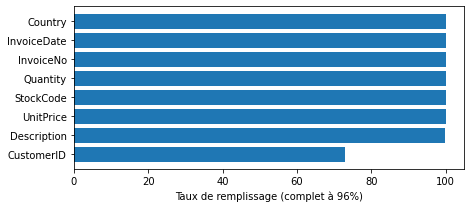

In [57]:
missing = source.isnull().sum().reset_index()
missing.columns = ['variables', 'nb vides']
missing['% remplissage'] = round(((source.shape[0] - missing['nb vides']) \
                                  / source.shape[0] * 100 ), 2)
missing = missing.sort_values(['nb vides', 'variables'], \
                              ascending=False).reset_index(drop = True)
fig = plt.figure(figsize=(7, 3))
plt.barh(missing['variables'], missing['% remplissage'] )
taille = source.shape[0] * source.shape[1]
plt.xlabel('Taux de remplissage (complet à {}%)'.\
           format(int((taille - missing['nb vides'].sum()) / taille*100)))

L'objectif de ce projet étant la segmentaiton client, je supprime les enregistrements dont leur identifiant est absent

In [58]:
source = source.dropna(subset=['CustomerID']).reset_index(drop=True)
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361878 entries, 0 to 361877
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  object        
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.1+ MB


## Description 
Uniformisation des descriptions de produits à partir de leur StockCode pour tenter de les catégoriser

In [59]:
test = source[['StockCode', 'Description']].drop_duplicates()
test[test.duplicated(subset='StockCode', keep=False)].sort_values(by=['StockCode'])

,StockCode,Description
83550,16156L,WRAP CAROUSEL
27550,16156L,"WRAP, CAROUSEL"
213413,17107D,FLOWER FAIRY 5 DRAWER LINERS
4171,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS"
224810,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS
...,...,...
22555,90014A,SILVER/MOP ORBIT NECKLACE
17085,90014B,GOLD M PEARL ORBIT NECKLACE
253550,90014B,GOLD M.O.P. ORBIT NECKLACE
338254,90014C,SILVER AND BLACK ORBIT NECKLACE


Création d'un référentiel des codes produits auxquels j'attribue la valeur modale des descriptions correspondantes

In [60]:
Pdt = source.groupby('StockCode').Description.agg(pd.Series.mode).reset_index()
Pdt.describe(include='all')

,StockCode,Description
count,3661,3661
unique,3661,3643
top,22341,"METAL SIGN,CUPCAKE SINGLE HOOK"
freq,1,3


Mise à jour du jeu de données à partir de mon référentiel produit

In [61]:
source.drop(['Description'], axis=1, inplace=True)
source = source.merge(Pdt, on="StockCode", )
source.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
count,361878,361878,361878.000000,361878,361878.000000,361878,361878,361878
unique,19857,3661,NaN,18441,NaN,3950,1,3643
top,576339,85123A,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
freq,542,1987,NaN,543,NaN,7983,361878,1987
first,NaN,NaN,NaN,2010-01-12 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2011-12-10 17:19:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,11.077029,NaN,3.256007,NaN,NaN,NaN
std,NaN,NaN,263.129266,NaN,70.654731,NaN,NaN,NaN
min,NaN,NaN,-80995.000000,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN,NaN


In [62]:
def most_common_words(labels, sep):
    words = []
    for i, lab in labels.items():
        lab = '|'.join([x.strip() for x in str(lab).split(sep) ])
        if lab != '':
            words += lab.split('|')
#    words.pop('')
    return Counter(words).most_common()

In [63]:
keywords = dict(most_common_words(source.Description, ' ') )
keywords_kp = {}
for k, v in keywords.items():
    if len(k) >= 3:
        keywords_kp[k] = v
len(keywords_kp )

2133

Les mots clés des descriptions sont nombreux : je reviendrai sur la segmentation produit 

si les autres  variables ne me permettent pas de segmenter les clients

## Codes produit (StockCode)
Recherche les codes produits qui ne correspondraient à la nomenclature attendue 

(cf. Contenu et caractéristiques du jeu de données)

In [64]:
mask = source.StockCode.str.contains('[0-9]{5}')
source[~mask][['StockCode', 'Description']].value_counts()

StockCode     Description               
M             Manual                        385
POST          POSTAGE                        86
D             Discount                       74
C2            CARRIAGE                       30
DOT           DOTCOM POSTAGE                 16
CRUK          CRUK Commission                16
BANK CHARGES  Bank Charges                   12
PADS          PADS TO MATCH ALL CUSHIONS      4
dtype: int64

Suppresion de ces enregistrements qui correspondent visiblement à des opérations spéciales de la part de Datazon et ne semblent donc pas des commandes cient

In [65]:
source.drop(index=source[~mask].index, inplace=True)

## Doublons 
Suppression des entrées dupliquées

In [66]:
print('Entrées dupliquées: {}'.\
      format(source.duplicated(subset=['InvoiceNo', 'StockCode', 'Quantity', \
                                       'InvoiceDate', 'UnitPrice', 'CustomerID']\
                               ).sum()))
source.drop_duplicates(inplace = True, \
                       subset=['InvoiceNo', 'StockCode', 'Quantity', \
                               'InvoiceDate', 'UnitPrice', 'CustomerID'], \
                       ignore_index=True)

Entrées dupliquées: 5147


In [67]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356108 entries, 0 to 356107
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356108 non-null  object        
 1   StockCode    356108 non-null  object        
 2   Quantity     356108 non-null  int64         
 3   InvoiceDate  356108 non-null  datetime64[ns]
 4   UnitPrice    356108 non-null  float64       
 5   CustomerID   356108 non-null  object        
 6   Country      356108 non-null  object        
 7   Description  356108 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.7+ MB


## Commandes annulées

In [68]:
# Tri du jeu de données (date, client, facture, produit, PU)
source = source.sort_values(by=['InvoiceDate', 'CustomerID', 'InvoiceNo', \
                                'StockCode', 'UnitPrice']).reset_index(drop=True)

In [69]:
mask = source.InvoiceNo.str.contains('^C', regex=True)

Dénombrement

In [70]:
nb_cancel = len(source[source.InvoiceNo.str.contains('^C', regex=True)].InvoiceNo)
nb_distinct = len(source.InvoiceNo)
print("Brutes : {}\nAnnulées : {}\nRatio {:.2f}%".\
      format(nb_distinct, nb_cancel, nb_cancel / nb_distinct * 100))

Brutes : 356108
Annulées : 7218
Ratio 2.03%


Pour supprimer les 7218 commandes annulées, je boucle pour : 
*   retirer les quantités annulées des commandes antérieures correspondantes (client/produit/prix unitaire) si la quantité annulée > commandée
*   retirer les quantités commandées des annulations correspondantes si quantité annulée > commandée 

Je m'arrête dès qu'une boucle n'a rien modifié. 



In [71]:
# Identification des commandes annulées
Cancel_Orders = source[source.InvoiceNo.str.contains('^C', regex=True) ].copy()

# Identifcation des commmandes dont les clients/produits sont
# ceux des commandes annulées
Orders = source[(~source.InvoiceNo.str.contains('^C', regex=True)) ].reset_index().\
                merge(Cancel_Orders[['CustomerID', 'UnitPrice', 'StockCode']].\
                      drop_duplicates())

end = Cancel_Orders.shape[0]

while end:
    print( "{} Orders, {} Cancels".format(len(Orders), len(Cancel_Orders)))
    Cnl_idx = []
    Can = 0
    c = 0
    o = 0
    # Pour chaque commande annulée, je recherche la plus récente commande
    # antérieure et similaire (client/produit/PU)
    for i, j in Cancel_Orders.iterrows():
        Can += 1
        if not Can % 1000:
            print(Can, c, o)
        try:
            idx = max( Orders[(Orders.CustomerID == j.CustomerID) & \
                              (Orders.UnitPrice == j.UnitPrice) & \
                              (Orders.StockCode == j.StockCode) & \
                              (Orders.InvoiceDate < j.InvoiceDate)]['index'])
            idx_ord = Orders[Orders['index'] == idx].index[0]

            ecart  = Orders.loc[idx_ord, 'Quantity'] + j.Quantity
            # si plus de commande que d'annulation, consommation de l'annulation juqu'à épuisement
            if ecart >= 0:
                c += 1
                Cnl_idx.append(i)
                if ecart == 0:
                    o += 1
                    Cnl_idx.append(idx)
                else:
                    source.loc[idx, 'Quantity'] = ecart
            # sinon, consommation des commandes jusqu'à épuisement
            else:
                source.loc[i, 'Quantity'] = ecart
                o += 1
                Cnl_idx.append(idx)
            Orders.drop(index=idx_ord, inplace=True)
        except ValueError:
            continue
    end = c
    print(Can, c, o, len(Cnl_idx), '\n')
    source.drop(index=Cnl_idx, inplace=True)
    Cancel_Orders = source[source.InvoiceNo.str.contains('^C', regex=True)].copy()
    Orders = source[(~source.InvoiceNo.str.contains('^C', regex=True))].reset_index().\
                    merge(Cancel_Orders[['CustomerID', 'UnitPrice', 'StockCode']].drop_duplicates())
#source.reset_index(drop=True, inplace=True)
source.describe(include='all')

13104 Orders, 7218 Cancels
1000 331 127
2000 882 370
3000 1461 582
4000 2083 859
5000 2841 1107
6000 3637 1390
7000 4455 1721
7218 4621 1783 6404 

2876 Orders, 2597 Cancels
1000 16 6
2000 76 24
2597 160 55 215 

2430 Orders, 2437 Cancels
1000 1 0
2000 6 1
2437 14 1 15 

2400 Orders, 2423 Cancels
1000 0 0
2000 3 1
2423 3 1 4 

2399 Orders, 2420 Cancels
1000 0 0
2000 3 2
2420 3 2 5 

2390 Orders, 2417 Cancels
1000 0 0
2000 0 0
2417 0 0 0 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
count,349465,349465,349465.000000,349465,349465.000000,349465,349465,349465
unique,17632,3652,NaN,16501,NaN,3939,1,3634
top,576339,85123A,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
freq,541,1939,NaN,541,NaN,7628,349465,1939
first,NaN,NaN,NaN,2010-01-12 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2011-12-10 17:19:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,11.424011,NaN,2.865400,NaN,NaN,NaN
std,NaN,NaN,49.962911,NaN,4.308526,NaN,NaN,NaN
min,NaN,NaN,-9360.000000,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN,NaN


Vérification sur un exemple

In [72]:
source[(source.StockCode == '71053') & (source.CustomerID == '16094')].sort_values(by='InvoiceDate')

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
144083,C540380,71053,-1,2011-06-01 17:36:00,3.75,16094,United Kingdom,WHITE METAL LANTERN
264876,C552701,71053,-1,2011-10-05 15:58:00,3.75,16094,United Kingdom,WHITE METAL LANTERN
271909,575698,71053,4,2011-10-11 16:51:00,3.75,16094,United Kingdom,WHITE METAL LANTERN


In [73]:
source[(source.Quantity <= 0) & \
       ~(source.InvoiceNo.str.contains('^C', regex=True)) ]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description


Les boucles de suppression n'ont pas produit de commandes avec des  quantités négatives. Je supprime les 2417 annulations de commandes non réconciliées

In [74]:
print("{} Cancels restantes".format(len(Cancel_Orders)) )
source.drop(index=Cancel_Orders.index, inplace=True)
source[source.InvoiceNo.str.contains('^C', regex=True)]

2417 Cancels restantes


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description


## Commandes avec des montants ou quantités nuls

In [75]:
mask = (source.UnitPrice == 0) | (source.Quantity == 0)
mask.sum()

20

In [76]:
source[(source.UnitPrice == 0) | (source.Quantity == 0)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
21028,539263,22580,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,ADVENT CALENDAR GINGHAM SACK
35239,541109,22168,1,2011-01-13 15:10:00,0.0,15107,United Kingdom,ORGANISER WOOD ANTIQUE WHITE
74165,574175,22065,12,2011-03-11 11:47:00,0.0,14110,United Kingdom,CHRISTMAS PUDDING TRINKET POT
83476,547417,22062,36,2011-03-23 10:25:00,0.0,13239,United Kingdom,CERAMIC BOWL WITH LOVE HEART DESIGN
89807,548318,22055,5,2011-03-30 12:45:00,0.0,13113,United Kingdom,MINI CAKE STAND HANGING STRAWBERY
94466,548871,22162,2,2011-04-04 14:42:00,0.0,14410,United Kingdom,HEART GARLAND RUSTIC PADDED
143929,540372,22090,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,PAPER BUNTING RETROSPOT
143955,540372,22553,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,PLASTERS IN TIN SKULLS
150273,569716,22778,2,2011-06-10 08:17:00,0.0,15804,United Kingdom,GLASS CLOCHE SMALL
182459,574879,22625,2,2011-07-11 13:22:00,0.0,13014,United Kingdom,RED KITCHEN SCALES


Suppression des 20 enregistrements trouvés (probablement des cadeaux de la part de Datazon)

In [82]:
source.drop(index=source[(source.UnitPrice == 0) | \
                         (source.Quantity == 0)].index, inplace=True)
source.reset_index(inplace=True, drop=True)

In [78]:
source.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Description    0
dtype: int64

# Exploration

In [83]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347028 entries, 0 to 347027
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    347028 non-null  object        
 1   StockCode    347028 non-null  object        
 2   Quantity     347028 non-null  int64         
 3   InvoiceDate  347028 non-null  datetime64[ns]
 4   UnitPrice    347028 non-null  float64       
 5   CustomerID   347028 non-null  object        
 6   Country      347028 non-null  object        
 7   Description  347028 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.2+ MB


## Calcul des montants totaux (TotalPrice)

In [33]:
source['TotalPrice'] = source.Quantity * source.UnitPrice
source.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,TotalPrice
0,536365,21730,6,2010-01-12 08:26:00,4.25,17850,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER,25.50
1,536365,22752,2,2010-01-12 08:26:00,7.65,17850,United Kingdom,SET 7 BABUSHKA NESTING BOXES,15.30
2,536365,71053,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,WHITE METAL LANTERN,20.34
3,536365,84029E,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34
4,536365,84029G,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,20.34


## Segmentation temporelle 
Bornes du jeu de données

In [34]:
print(source['InvoiceDate'].min(), '->',  source['InvoiceDate'].max())

2010-01-12 08:26:00 -> 2011-12-10 17:19:00


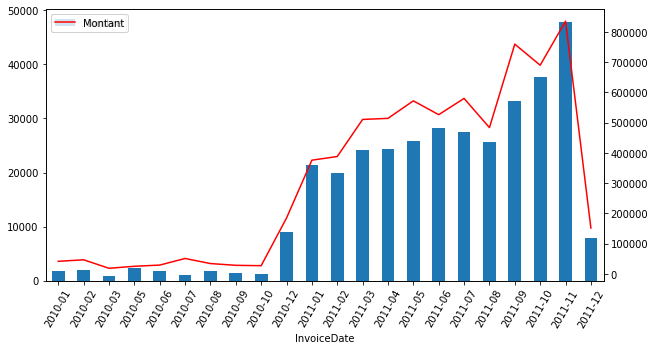

In [35]:
fig = plt.figure(figsize=(10, 5) )
tmp = source.groupby(source.InvoiceDate.dt.strftime('%Y-%m')).TotalPrice.\
             agg([('Nombre', 'count'),('Montant', 'sum')])
ax1 = plt.subplot()
tmp.plot(kind='bar', y='Nombre', ax=ax1)
plt.xticks(rotation=60)
ax2 = ax1.twinx()
tmp.plot(y='Montant', kind='line', color='red', ax=ax2)

In [36]:
backup = source.copy()

L'activité de Datazon semble réellement commencer en Janv. 2011. Le dernier mois couvert s'arrête au 10 Déc. 2011. 

Je limite donc mon jeu de données aux 11 premiers mois de 2011

In [37]:
source = backup.copy()
source = source[(source.InvoiceDate >= '2011-01-01') & \
                (source.InvoiceDate < '2011-12-01')]

## Agrégation client 
Ma proposition est de classer les clients en Platinum/Gold/Silver/Bronze. 

A cet effet, je m'inspire de la [démarche marketing RFM](https://fr.wikipedia.org/wiki/R%C3%A9cence,_Fr%C3%A9quence,_Montant#:~:text=La%20m%C3%A9thode%20de%20segmentation%20RFM,achat%20ou%20dernier%20contact%20client) et ajoute d'autres variables qui pourraient servir : 
*   Récence : durée depuis le dernier achat client (recency) 
*   Fréquence : fréquence des achats sur une période de référence donnée (frequency) 
*   Montant : somme des achats cumulés sur cette période (monetary_value)
*   la durée entre le 1° et le dernier achat (duration) 
*   le nombre de commandes distinctes (orders)
*   le nombre de produits total achetés par un utilisateur (pdt_mean) 
*   la quantité moyenne par transaction (line_mean)
*   le nb moyen d'articles différents par achat (pdt_mean)
*   le prix moyen des produits achetés par transaction (price_mean)
*   le nombre de produits différents achetés 


Pour calculer la récence, je me place au lendemain de la date de commande la plus récente

In [38]:
d_study = source.InvoiceDate.max() + timedelta(days=1)
d_study

Timestamp('2011-12-01 17:37:00')

Création de la synthèse client RFM

In [39]:
rfmTable = preprocess_df(source)
rfmTable.describe()

,recency,duration,orders,frequency,line_mean,pdt_mean,monetary_value,price_mean,nb_pdt
count,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000
mean,90.642270,116.176611,3.925484,83.778308,21.717025,21.364914,1652.264834,41.942782,58.082471
std,90.356066,116.503133,6.354222,200.680616,19.790848,19.140968,6276.189656,351.444674,77.791890
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.900000,1.450000,1.000000
25%,16.000000,1.000000,1.000000,16.000000,9.000000,9.000000,283.400000,12.105000,15.000000
50%,56.000000,89.000000,2.000000,39.000000,16.750000,16.670000,611.880000,17.640000,34.000000
75%,147.000000,225.000000,4.000000,92.000000,27.635000,27.290000,1483.360000,25.985000,72.500000
max,333.000000,333.000000,164.000000,7064.000000,299.710000,297.880000,231822.690000,19809.750000,1582.000000


*   Attribution des "points" RFM, fonction des quartiles des 3 variables
*   Pour comparer, j'étiquette de façon arbitraire les clients en Platinum/Gold/Silver/Bronze 
en fonction du score obtenu 



In [40]:
rfmTable = scoring_RFM(rfmTable, 4)
count = pd.DataFrame(rfmTable['General_Segment'].value_counts()).reset_index()
count.columns = ['General_Segment', 'nb']
rfmTable.groupby('General_Segment').mean().round(2).reset_index().merge(count)

,General_Segment,recency,duration,orders,frequency,line_mean,pdt_mean,monetary_value,price_mean,nb_pdt,RFM_Score,nb
0,Bronze,178.79,19.52,1.27,14.67,12.82,12.68,242.24,31.01,14.26,10.86,1101
1,Gold,29.45,213.75,6.22,145.89,29.53,28.97,2704.28,27.39,105.23,4.52,747
2,Platinum,7.43,278.63,13.86,341.54,29.11,28.71,7338.47,31.79,177.22,3.00,351
3,Silver,76.57,101.24,2.48,45.11,22.59,22.19,870.28,58.78,39.77,7.57,1572


### Focus sur les commandes uniques

In [41]:
print('{:.2f}% de commandes uniques pour un panier moyen de {:.2f}'.\
      format(len(rfmTable[rfmTable.orders == 1]) / len(rfmTable) *100, \
             rfmTable[rfmTable.orders == 1].monetary_value.mean()))

36.22% de commandes uniques pour un panier moyen de 324.53


## Distribution des variables

In [42]:
quantiles = rfmTable.iloc[:, 1:10].quantile(q=[.25, .5, .75]).round(2)
quantiles = quantiles.to_dict()

quantiles['recency']['asc'] = False
quantiles['recency']['coef'] = 100

quantiles['frequency']['asc'] = True
quantiles['frequency']['coef'] = 10

quantiles['monetary_value']['asc'] = True
quantiles['monetary_value']['coef'] = 1

quantiles

{'duration': {0.25: 1.0, 0.5: 89.0, 0.75: 225.0},
 'frequency': {0.25: 16.0, 0.5: 39.0, 0.75: 92.0, 'asc': True, 'coef': 10},
 'line_mean': {0.25: 9.0, 0.5: 16.75, 0.75: 27.64},
 'monetary_value': {0.25: 283.4,
  0.5: 611.88,
  0.75: 1483.36,
  'asc': True,
  'coef': 1},
 'nb_pdt': {0.25: 15.0, 0.5: 34.0, 0.75: 72.5},
 'orders': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0},
 'pdt_mean': {0.25: 9.0, 0.5: 16.67, 0.75: 27.29},
 'price_mean': {0.25: 12.1, 0.5: 17.64, 0.75: 25.98},
 'recency': {0.25: 16.0, 0.5: 56.0, 0.75: 147.0, 'asc': False, 'coef': 100}}

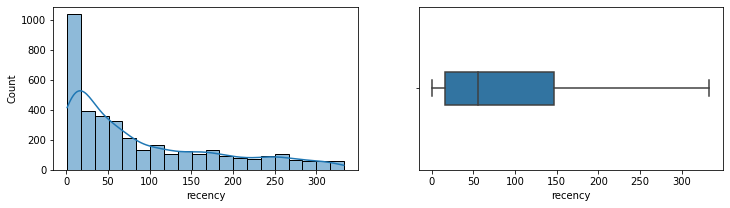

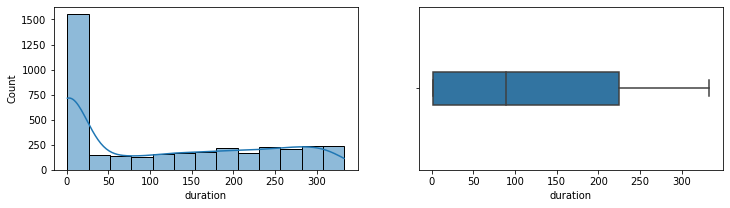

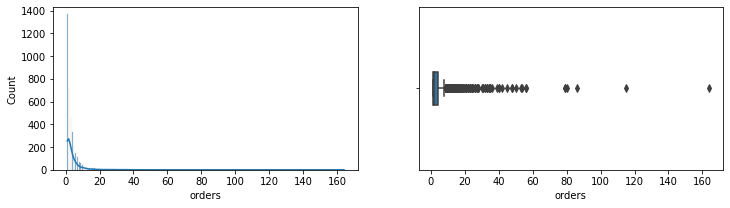

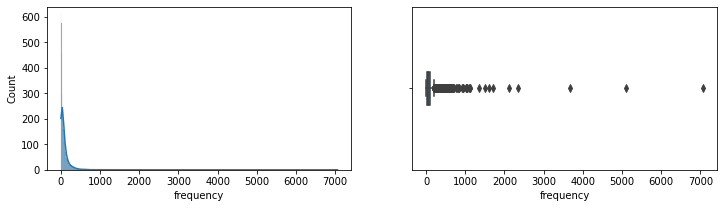

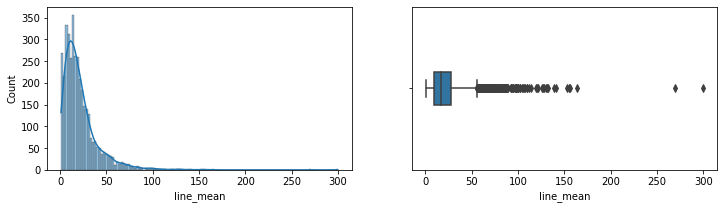

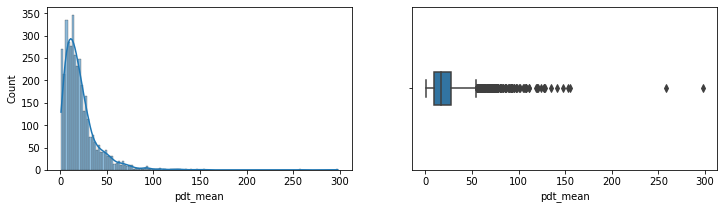

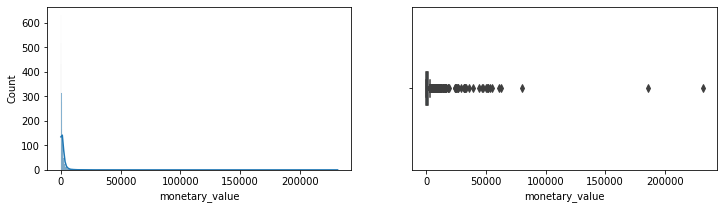

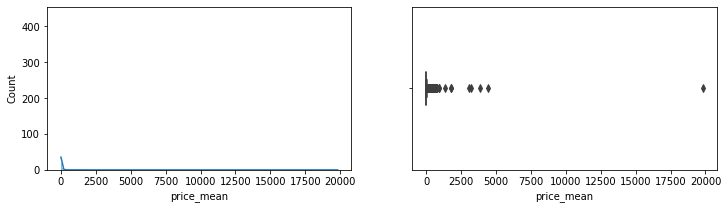

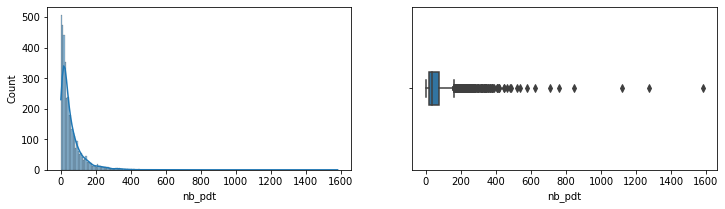

In [43]:
for col in quantiles.keys(): #quantiles.keys():
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    sns.histplot(rfmTable[[col]], x=col, kde=True)
    plt.subplot(122)
    sns.boxplot(x=rfmTable[col], width=0.2)

Pour diminuer la disymétie (skewness) et améliorer la performance du clustering à venir,

j'applique une transformation logarythmique à ma synthèse

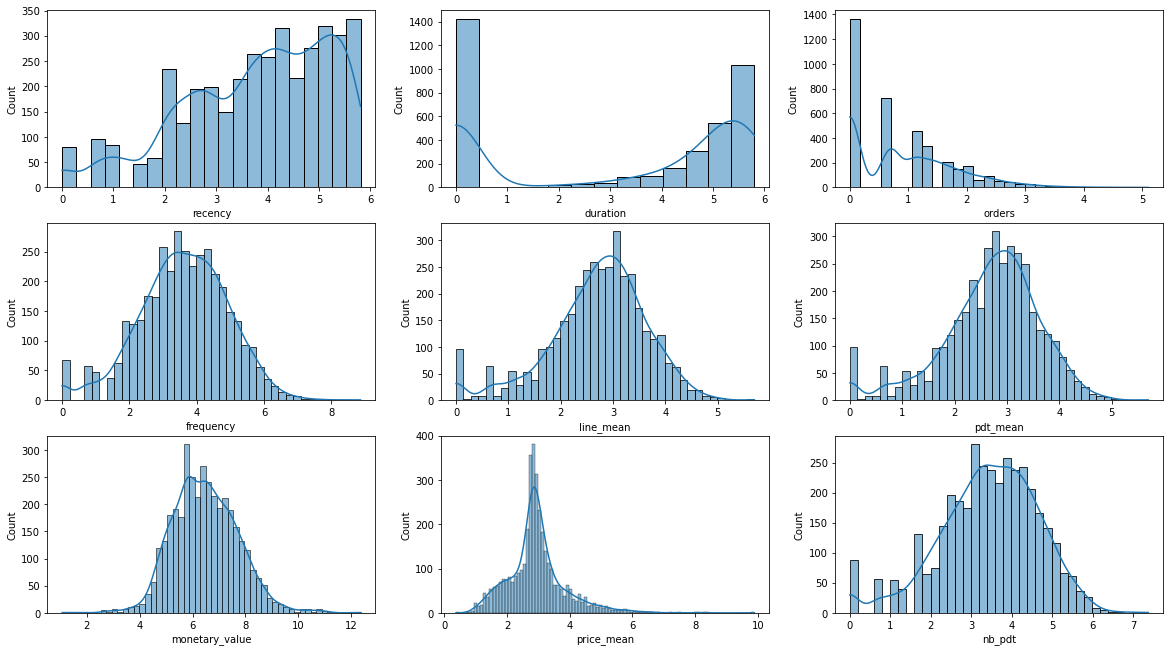

In [44]:
#Unskew the data with log transformation
rfm_log = np.log(rfmTable[list(quantiles.keys())])
c = 1
plt.figure(figsize=(20, 15))
for col in rfm_log.columns:
    lin = len(rfm_log.columns) // 3 + 1
    plt.subplot(lin, 3, c)
    sns.histplot(rfm_log[[col]], x=col, kde=True)
    c += 1

## Analyse bivariée

Outliers 'recency' 0
Outliers 'frequency' 327
Outliers 'monetary_value' 341
Outliers 'orders' 358


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


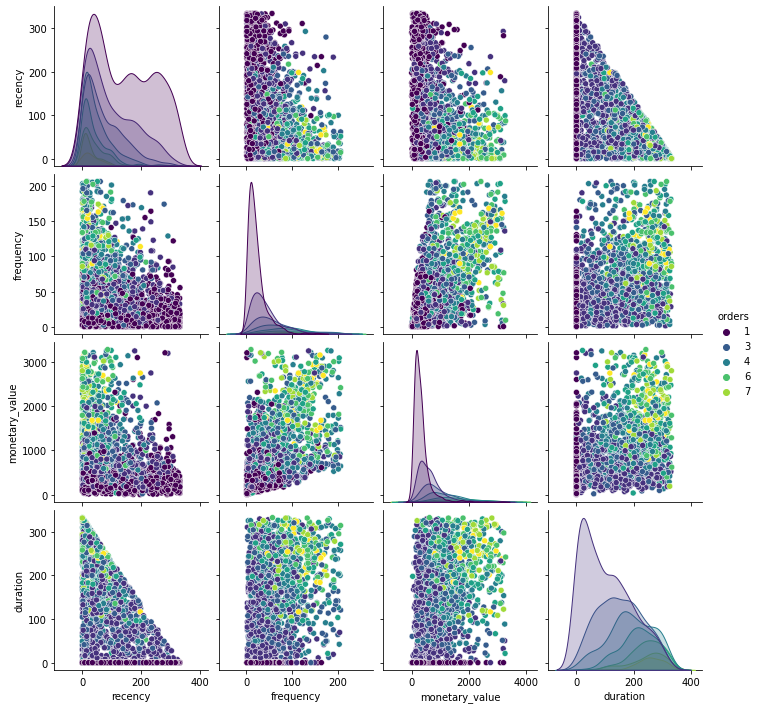

In [45]:
outliers_lst  = []
dict_outliers = {}

temp = rfmTable.copy()

# For each feature find the data points with extreme high or low values
for feature in ['recency', 'frequency', 'monetary_value', 'orders']:
    Q1 = quantiles[feature][.25]
    Q3 = quantiles[feature][.75]
    step = 1.5 * (Q3 - Q1)

    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = temp.loc[~((rfmTable[feature] >= Q1 - step) & \
                               (temp[feature] <= Q3 + step)), :]

    # Display the outliers
    print ("Outliers '{}' {}".format(feature, len(outliers_rows)))

    outliers_lst.append(list(outliers_rows.index))
    #dict_outliers[feature] = temp.iloc[outliers_rows.index, :].copy()

outliers = list(itertools.chain.from_iterable(outliers_lst))

temp.drop(index=list(set(outliers)), inplace=True)
temp.reset_index(drop=True)

sns.pairplot(temp[['recency', 'frequency', 'monetary_value', \
                   'duration', 'orders']], palette='viridis', hue='orders')

In [46]:
with open('OC_DS_P5_temp.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(rfm_log)
    pickler.dump(source)
    pickler.dump(rfmTable)